In [18]:
import os
import cv2
import glob
import matplotlib.pyplot as plt
from skimage import io
import rioxarray as rxr
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np
from PIL import Image 
from constants import labels

from constants import labels
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import copy
import time
from collections import defaultdict

import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
import torch.nn.functional as F

import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint

In [19]:
class OpenSendaiBenchDataset(Dataset):
    """
    An implementation of a PyTorch dataset for loading pairs of observable variables and ground truth labels.
    Inspired by https://pytorch.org/tutorials/beginner/data_loading_tutorial.html.
    """
    def __init__(self, obsvariables_path: str, groundtruth_path: str, country: str, signals: list, transform: transforms = None):
        """
        Constructs an OpenSendaiBenchDataset.
        :param obsvariables_path: Path to the source folder of observable variables
        :param groundtruth_path: Path to the source folder of corresponding ground truth labels
        :param transform: Callable transformation to apply to images upon loading
        """
        self.obsvariables_path = obsvariables_path
        self.groundtruth_path = groundtruth_path
        self.country = country
        self.signals = signals
        self.transform = transform

    def __len__(self):
        """
        Implements the len(SeaIceDataset) magic method. Required to implement by Dataset superclass.
        When training/testing, this method tells our training loop how much longer we have to go in our Dataset.
        :return: Length of OpenSendaiBenchDataset
        """
        return 100 #len(self.groundtruth_files)/labels[self.country]

    def __getitem__(self, i: int):
        """
        Implements the OpenSendaiBenchDataset[i] magic method. Required to implement by Dataset superclass.
        When training/testing, this method is used to actually fetch data.
        :param i: Index of which image pair to fetch
        :return: Dictionary with pairs of observable variables and ground truth labels.
        """

        obsvariable = np.zeros([len(self.signals),372,372])
        obsvariable_8x8 = np.zeros([len(self.signals),8,8])
        for s in range(len(self.signals)):
            for file in glob.glob(str(os.getcwd()+self.obsvariables_path+
                                    '**/'+self.country+'_*/'+self.country+'_'+
                                    str(i)+'_'+'of_*/2019*_'+self.signals[s]+'.tif')):
                a = cv2.imread(file, cv2.IMREAD_UNCHANGED)
                a = a.reshape(1,a.shape[0],a.shape[1])
                obsvariable[s,:,:] = a[0,0:372,0:372]
            obsvariable_8x8[s,:,:] = cv2.resize(obsvariable[s,:,:], (8,8), interpolation = cv2.INTER_AREA)

        groundtruth = np.zeros([len(labels[self.country]),8,8])
        for w in range(len(labels[self.country])): # to make composite. in AFG, we got 5 bldgtypes
            for file in glob.glob(str(os.getcwd()+self.groundtruth_path+
                                      self.country+'*/tiles/images/'+
                                      self.country+'_nbldg_'+labels[self.country][w]+'_'+str(i)+'_'+'of_'+'*.tif')):
                a = cv2.imread(file, cv2.IMREAD_UNCHANGED)
                # a = cv2.resize(a, (372,372), interpolation = cv2.INTER_NEAREST)
                a = a.reshape(1,a.shape[0],a.shape[1])
                groundtruth[w,:,:] = a

        obsvariable = torch.from_numpy(obsvariable).float()
        obsvariable_8x8 = torch.from_numpy(obsvariable_8x8).float()
        groundtruth = torch.from_numpy(groundtruth).float()
    
        sample = {"obsvariable": obsvariable_8x8, "groundtruth": groundtruth}
        if self.transform:
            sample = {"obsvariable": self.transform(obsvariable_8x8),
                      "groundtruth": self.transform(groundtruth).squeeze(0).long()}
        return sample

    def visualise(self, i):
        """
        Allows us to visualise a particular SAR/chart pair.
        :param i: Index of which image pair to visualise
        :return: None
        """
        sample = self[i]
        fig1, axs1 = plt.subplots(1,len(self.signals))
        for s in range(len(self.signals)):
            axs1[s].imshow(sample['obsvariable'][s,:,:])
            axs1[s].set_title(str(self.signals[s]))
            axs1[s].set_xticks([])
            axs1[s].set_yticks([])
        plt.tight_layout()
 
        fig2, axs2 = plt.subplots(1,len(labels[self.country]))
        for w in range(len(labels[self.country])): 
            axs2[w].imshow(sample['groundtruth'][w,:,:])
            axs2[w].set_title(labels[self.country][w])
            axs2[w].set_xticks([])
            axs2[w].set_yticks([])
        plt.tight_layout()

In [20]:
train_dataset = OpenSendaiBenchDataset( obsvariables_path="/obsvariables/", 
                                        groundtruth_path="/groundtruth/", 
                                        country='AFG', 
                                        signals = ['VH','VV','aerosol','blue','green','red','red1','red2','red3','nir','red4','vapor','swir1','swir2'])

In [21]:
# class UNet(nn.Module):
#     def __init__(self, n_class:int):
#         super().__init__()

#         self.e11 = nn.Conv2d(in_channels=14, out_channels=64, kernel_size=4, padding=1)
#         self.e12 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, padding=1) 
#         self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

#         self.e21 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, padding=1)
#         self.e22 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=4, padding=1) 
#         self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

#         self.e31 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, padding=1)
#         self.e32 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=4, padding=1) 
#         self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
#         self.e41 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, padding=1)
#         self.e42 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=4, padding=1) 
#         self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
#         self.e51 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, padding=1) 
#         self.e52 = nn.Conv2d(in_channels=1024, out_channels=n_class, kernel_size=12, padding=1) 

#     def forward(self, x: torch.Tensor):

#         xe11 = relu(self.e11(x))
#         xe12 = relu(self.e12(xe11))
#         xp1 = self.pool1(xe12)

#         xe21 = relu(self.e21(xp1))
#         xe22 = relu(self.e22(xe21))
#         xp2 = self.pool2(xe22)

#         xe31 = relu(self.e31(xp2))
#         xe32 = relu(self.e32(xe31))
#         xp3 = self.pool3(xe32)

#         xe41 = relu(self.e41(xp3))
#         xe42 = relu(self.e42(xe41))
#         xp4 = self.pool4(xe42)

#         xe51 = relu(self.e51(xp4))
#         xe52 = relu(self.e52(xe51))

#         return xe52

In [ ]:
model = UNet(n_class=len(labels['AFG']))
output = model(train_dataset[1]['obsvariable'])


In [22]:
class Segmentation(pl.LightningModule):
    """
    A LightningModule designed to perform image segmentation.
    """

    def __init__(self,
                 train_dataloader: DataLoader,
                 val_dataloader: DataLoader,
                 model: nn.Module,
                 criterion: callable,
                 learning_rate: float,
                 metric: callable,
                 ):
        """
        Construct a Segmentation LightningModule.
        Note that we keep hyperparameters separate from dataloaders to prevent data leakage at test time.
        :param train_dataloader: Dataloader with training data, left as None at test time
        :param val_dataloader: Dataloader with validation data, left as None at test time
        :param model: PyTorch model
        :param criterion: PyTorch loss function against which to train model
        :param learning_rate: Float learning rate for our optimiser
        :param metric: PyTorch function for model evaluation
        """
        super().__init__()
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.model = model
        self.criterion = criterion
        self.learning_rate = learning_rate
        self.metric = metric

    def training_step(self, batch: dict, batch_idx: int):
        """
        Perform a pass through a batch of training data.
        :param batch: Batch of image pairs
        :param batch_idx: Index of batch
        :return: Loss from this batch of data for use in backprop
        """
        x, y  = batch["obsvariable"], batch["groundtruth"]
        y_hat = self.model(x)
        # loss = torch.sqrt(self.criterion(y_hat, y)+1e-6)
        loss = self.criterion(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y  = batch["obsvariable"], batch["groundtruth"]
        y_hat = self.model(x)
        # loss = torch.sqrt(self.criterion(y_hat, y)+1e-6)
        loss = self.criterion(y_hat, y)
        metric = self.metric(y_hat, y)
        self.log("val_loss", loss)
        self.log("val_metric", metric)
        return loss

    def testing_step(self, batch, batch_idx):
        x, y  = batch["sar"], batch["chart"]
        y_hat = self.model(x)
        # loss = torch.sqrt(self.criterion(y_hat, y)+1e-6)
        loss = self.criterion(y_hat, y)
        metric = self.metric(y_hat, y)
        self.log("test_loss", loss)
        self.log("test_metric", metric)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return {
            "optimizer": optimizer
        }

In [23]:
train_dataset = OpenSendaiBenchDataset( obsvariables_path="/obsvariables/", 
                                        groundtruth_path="/groundtruth/", 
                                        country='AFG', 
                                        signals = ['VH','VV','aerosol','blue','green','red','red1','red2','red3','nir','red4','vapor','swir1','swir2'])
train_dataloader = DataLoader(train_dataset, shuffle=True)
val_dataset = OpenSendaiBenchDataset(   obsvariables_path="/obsvariables/", 
                                        groundtruth_path="/groundtruth/", 
                                        country='AFG', 
                                        signals = ['VH','VV','aerosol','blue','green','red','red1','red2','red3','nir','red4','vapor','swir1','swir2'])
val_dataloader = DataLoader(val_dataset, shuffle=True)


In [24]:
torch.manual_seed(0)
model = UNet(n_class=len(labels['AFG']))
criterion = nn.MSELoss()
learning_rate = 1e-4
metric = nn.MSELoss()
segmenter = Segmentation(train_dataloader, val_dataloader, 
                         model, criterion, learning_rate, metric)

In [25]:
import wandb
wandb.init(project="opensendaibench")  # initialise wandb
wandb_logger = pl.loggers.WandbLogger(project="opensendaibench")  # create a logger object
wandb_logger.watch(model, log="all", log_freq=10)  # tell our logger to watch the model we are training to track parameters and gradients
wandb_logger.experiment.config.update(  # log experimental config items of interest
    {
        "learning_rate": learning_rate
    }
)

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


/Users/joshuadimasaka/miniconda3/envs/opensendaibench/lib/python3.11/site-packages/pytorch_lightning/loggers/wandb.py:389: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [26]:
from pytorch_lightning.callbacks import ModelCheckpoint
trainer = pl.Trainer(max_epochs=10) 
trainer.logger = wandb_logger  
trainer.callbacks.append(ModelCheckpoint(monitor="val_loss")) 
trainer.fit(segmenter, train_dataloader, val_dataloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type    | Params
--------------------------------------
0 | model     | UNet    | 26.3 M
1 | criterion | MSELoss | 0     
2 | metric    | MSELoss | 0     
--------------------------------------
26.3 M    Trainable params
0         Non-trainable params
26.3 M    Total params
105.139   Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/joshuadimasaka/miniconda3/envs/opensendaibench/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/Users/joshuadimasaka/miniconda3/envs/opensendaibench/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


RuntimeError: Calculated padded input size per channel: (4 x 4). Kernel size: (5 x 5). Kernel size can't be greater than actual input size

[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


Text(0.5, 1.0, 'Predicted Chart')

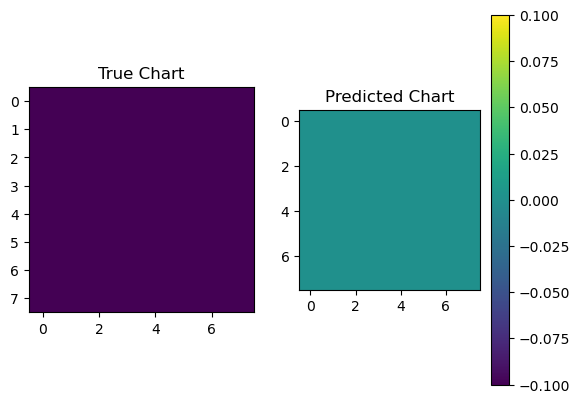

In [66]:
i = 3
j = 0
output = model(val_dataset[j]['obsvariable'])
output = output.detach().numpy()
map = output[i,:,:]
print(map)

plt.subplot(1, 2, 1)
plt.imshow(val_dataset[j]["groundtruth"][i,:,:])
plt.title("True Chart")

plt.subplot(1, 2, 2)
img = plt.imshow(map)
plt.colorbar(img)
plt.title("Predicted Chart")